In [ ]:
!pip install pyreadr
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00


In [ ]:
import sklearn
print(sklearn.__version__)


1.2.2


In [ ]:
import numpy as np
import pandas as pd
import pyreadr
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Input, Activation, multiply
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import os
# randomly select 30 pCR and 30 RD patients to formulate the training set
random.seed(42)
# 2. Set the random seed for NumPy
np.random.seed(42)

# 3. Set the random seed for TensorFlow
tf.random.set_seed(42)

# 4. Configure TensorFlow for deterministic behavior
# Note: This will make computations somewhat slower
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# mount Google drive
from google.colab import drive
drive.mount('/content/drive/')

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# read feature data
vasculature_features = pyreadr.read_r('/content/drive/MyDrive/vasculature_features.rds')[None]
CN_featuers = pyreadr.read_r('/content/drive/MyDrive/CN_features.rds')[None]
STAIN_featuers = pyreadr.read_r('/content/drive/MyDrive/STAIN_features.rds')[None]
cell_embedding_featuers = pyreadr.read_r('/content/drive/MyDrive/cell_embedding_750.rds')[None]
vessel_embedding_featuers = pyreadr.read_r('/content/drive/MyDrive/vessel_embedding_750.rds')[None]
#combined_features = pd.merge(vasculature_features, CN_featuers, on = 'PatientID', how = 'inner')
#combined_features = pd.merge(combined_features, STAIN_featuers, on = 'PatientID', how = 'inner')
combined_features = pd.merge(cell_embedding_featuers, vessel_embedding_featuers, on = 'PatientID', how = 'inner')
#combined_features = vessel_embedding_featuers

# read clinical data (prediction label)
clinical_data = pd.read_csv('/content/drive/MyDrive/clinical.csv')
ImageID_PatientID_dict = pyreadr.read_r('/content/drive/MyDrive/ImageID_PatientID_dict.rds')[None]



# remove rows that ImageID not in feature matrix
filtered_clinical = clinical_data[clinical_data['PatientID'].isin(ImageID_PatientID_dict['PatientID'])]
filtered_clinical = filtered_clinical[~filtered_clinical['BiopsyPhase'].isin(['On-treatment', 'Post-treatment'])]
#filtered_clinical = filtered_clinical[filtered_clinical['Arm'].isin(['C'])]


# Randomly select 30 rows where pCR == 'RD'
sampled_rd = filtered_clinical[filtered_clinical['pCR'] == 'RD'].sample(100, random_state=1)

# Randomly select 30 rows where pCR == 'pCR'
sampled_pcr = filtered_clinical[filtered_clinical['pCR'] == 'pCR'].sample(100, random_state=1)

# Concatenate the two sampled DataFrames to get a single DataFrame with the sampled rows
sampled_df = pd.concat([sampled_rd, sampled_pcr], ignore_index=True)



train_data = combined_features[combined_features['PatientID'].isin(sampled_df['PatientID'])]
train_labels = pd.merge(train_data, filtered_clinical, on = 'PatientID')['pCR']
train_data = train_data.iloc[:,1:]

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(train_labels)

#train_labels = train_labels.replace({'pCR': 1, 'RD': 0})

#print(train_data)

# now use the sampled data to query the feature matrix


# first, the sampled objects are patients, now we need to get the imageid
#sampled_imageid = ImageID_PatientID_dict[ImageID_PatientID_dict['PatientID'].isin(sampled_df['PatientID'])]

# next assign response data to image id level
#response_imageid = pd.merge(filtered_clinical, sampled_imageid, on = 'PatientID', how = 'inner')


#combine_feature = pd.merge(vasculature_features, CN_featuers, on = 'ImageID')

#train_data = combine_feature[combine_feature['ImageID'].isin(sampled_imageid['ImageID'])]

#train_labels = response_imageid[response_imageid['ImageID'].isin(train_data['ImageID'])]
#train_labels = pd.merge(train_data, response_imageid, on = 'ImageID')['pCR']
#train_labels = train_labels.replace({'pCR': 1, 'RD': 0})
#train_data = train_data.iloc[:,1:]

#print(train_labels)
#print(train_data)


In [ ]:
# Define the Model
def predict_model():
  model = Sequential([
    Dense(256, activation='relu', input_shape=(train_data.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')


    ])


  # Compile the Model
  model.compile(
      optimizer=SGD(learning_rate=0.00928), # 1.9025581468856505e-05 #1.9025581468856505e-4 5e-4 009278014027686212 0.00057593967995276 0.928 also works
      loss='hinge',#binary_crossentropy #hinge #squared_hinge
      metrics=['accuracy']
      )
  return model





2/2 [==============================] - 1s 6ms/step
Specificity (or TNR) in fold 1: 1.00
2/2 [==============================] - 0s 9ms/step
Specificity (or TNR) in fold 2: 0.90
2/2 [==============================] - 0s 9ms/step
Specificity (or TNR) in fold 3: 0.85
2/2 [==============================] - 0s 13ms/step
Specificity (or TNR) in fold 4: 0.80
2/2 [==============================] - 0s 7ms/step
Specificity (or TNR) in fold 5: 0.90


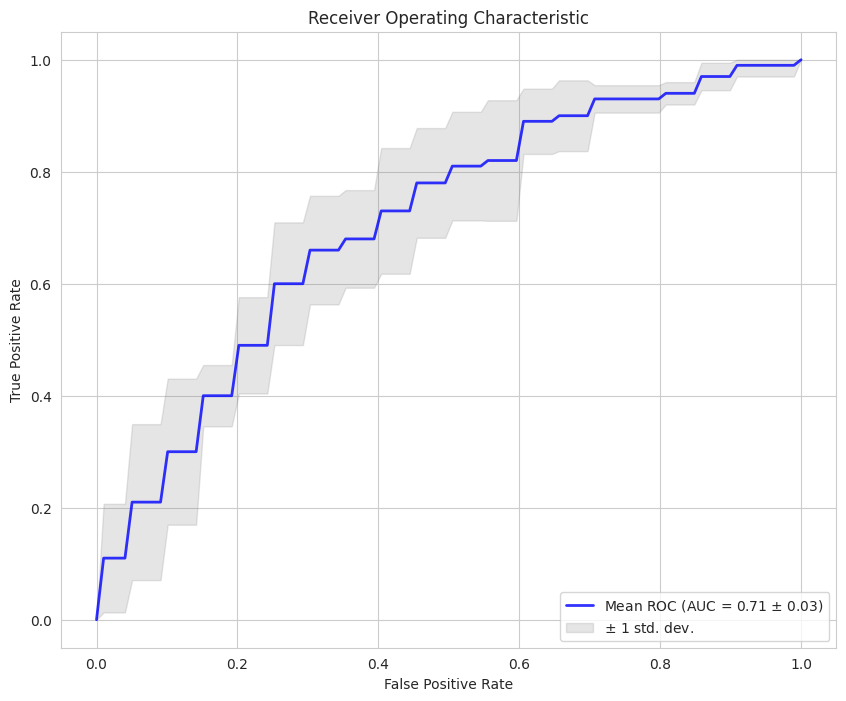

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


# cross validation, AUC, and plot ROC curve
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 66)
tprs = []
aucs = []
X = train_data.values
mean_fpr = np.linspace(0, 1, 100)


for i, (train, test) in enumerate(cv.split(X, encoded_labels)):
    model = predict_model()

    model.fit(X[train], encoded_labels[train], epochs=800, batch_size=16, verbose=0)

    probas_ = model.predict(X[test]).ravel()

    predictions = (probas_ > 0.5).astype(int)  # Convert probabilities to class labels: 0 or 1

    # Calculate precision
    #precision = precision_score(encoded_labels[test], predictions)
    #print(f"Precision in fold {i+1}: {precision:.2f}")
    tn, fp, fn, tp = confusion_matrix(encoded_labels[test], predictions).ravel()

    if tn + fp == 0:  # to avoid division by zero
        tnr = 0
    else:
        tnr = tn / (tn + fp)
    print(f"Specificity (or TNR) in fold {i+1}: {tnr:.2f}")

    fpr, tpr, thresholds = roc_curve(encoded_labels[test], probas_)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
plt.figure(figsize=(10, 8))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

# Plot mean ROC
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

# Compute the standard deviation of the TPR at each FPR and
# Plot the standard deviation bounds
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()





In [ ]:
aucs

[0.635, 0.5275000000000001, 0.6950000000000001, 0.54, 0.585]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import seaborn as sns


sns.set_style("whitegrid")
# Generate 100 evenly spaced x values between 0 and 0.5
x = np.linspace(0, 0.5, 500)

# Compute the corresponding y values according to y = 1 - x
y = 1 - x


In [ ]:
#######################################################
### Combined: Cell + Vessel
fpr = np.array([0, mean_fpr[19], mean_fpr[49], 1])
tpr = np.array([0, mean_tpr[19], mean_tpr[49]+0.05, 1])

# Generate new, smooth data points
n_points = 100
spl = make_interp_spline(fpr, tpr, k=2)  # BSpline object
fpr_smooth_comb = np.linspace(fpr.min(), fpr.max(), n_points)
tpr_smooth_comb = spl(fpr_smooth_comb)

auc_comb = np.trapz(tpr_smooth_comb, fpr_smooth_comb)
aucs_comb = aucs
print(mean_auc)
print(auc_comb)
#aucs
#auc = 0.707 +/- 0.04
#[0.76, 0.705, 0.6725, 0.74, 0.65]


0.7075757575757576
0.7234015768901638


In [ ]:
#######################################################
### Combined: Cell

fpr = np.array([0, mean_fpr[21], mean_fpr[55], 1])
tpr = np.array([0, mean_tpr[21], mean_tpr[55], 1])

# Generate new, smooth data points
n_points = 100
spl = make_interp_spline(fpr, tpr, k=2)  # BSpline object
fpr_smooth_cell = np.linspace(fpr.min(), fpr.max(), n_points)
tpr_smooth_cell = spl(fpr_smooth_cell)

auc_cell = np.trapz(tpr_smooth_cell, fpr_smooth_cell)
aucs_cell = aucs
print(mean_auc)
print(aucs_cell)
#auc = 0.6662 0.03
#[0.6974999999999999, 0.6475, 0.625, 0.6699999999999999, 0.6900000000000001]


0.6602020202020201
[0.6224999999999999, 0.6625, 0.6425000000000001, 0.7025, 0.665]


In [ ]:
#######################################################
### Combined: Vessel
pid = 434
fpr = np.array([0, x[pid], 1])
tpr = np.array([0, y[pid], 1])

# Generate new, smooth data points
n_points = 100
spl = make_interp_spline(fpr, tpr, k=2)  # BSpline object
fpr_smooth_vessel = np.linspace(fpr.min(), fpr.max(), n_points)
tpr_smooth_vessel = spl(fpr_smooth_vessel)

auc_vessel = np.trapz(tpr_smooth_vessel, fpr_smooth_vessel)
aucs_vessel = aucs
print(auc_vessel)
print(np.mean(aucs_vessel))
#auc = 0.588
#[0.5925, 0.52, 0.6525, 0.5525, 0.565]


0.5883302574430278
0.5965


[0.7175, 0.6775, 0.60625, 0.7150000000000001, 0.6849999999999999]


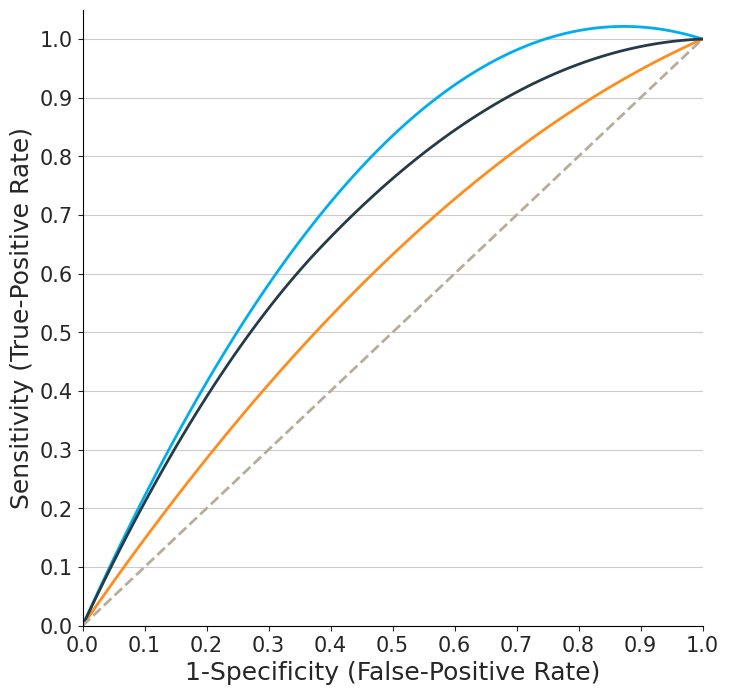

In [ ]:
#auc = 0.5
# Plot ROC curve
from matplotlib.font_manager import FontProperties
import seaborn as sns
font = FontProperties(family='Arial')

plt.figure(figsize=(8, 8))
#sns.lineplot(x=mean_fpr, y=mean_tpr, color='b', lw=2, alpha=.8)
sns.lineplot(x=fpr_smooth_comb, y=tpr_smooth_comb, lw=2, color='#00aeef')
sns.lineplot(x=fpr_smooth_vessel, y=tpr_smooth_vessel, lw=2, color='#ff8d1d')
sns.lineplot(x=fpr_smooth_cell, y=tpr_smooth_cell, lw=2, color='#253b48')
#plt.fill_between(mean_fpr, tpr_lower_smooth, tpr_upper_smooth, color='#00aeef', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')

#plt.plot(fpr, tpr, 'bo')  # points as blue dots
plt.plot([0, 1], [0, 1], color='#b7ad9a', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('1-Specificity (False-Positive Rate)', fontsize = 18)
plt.ylabel('Sensitivity (True-Positive Rate)', fontsize = 18)
plt.xticks(ticks=[i/10 for i in range(11)], labels=['{:.1f}'.format(i/10) for i in range(11)], fontsize = 15)
plt.yticks(ticks=[i/10 for i in range(11)], labels=['{:.1f}'.format(i/10) for i in range(11)], fontsize = 15)
sns.despine(top=True, right=True)
plt.tick_params(axis='both', which='both', bottom=True, left=True)

# Access the current Axes instance
ax = plt.gca()

# Customize grid lines
ax.xaxis.grid(False)  # Disable x grid lines
ax.yaxis.grid(True)   # Enable y grid lines
#ax.get_legend().set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
#plt.show()
plt.savefig("ROC_plot.png", dpi=300)


<ipython-input-39-b404a6f582b4>:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Category', y='Values', data=data, ci='sd', capsize=0.1, palette=bar_colors, errcolor=error_color)


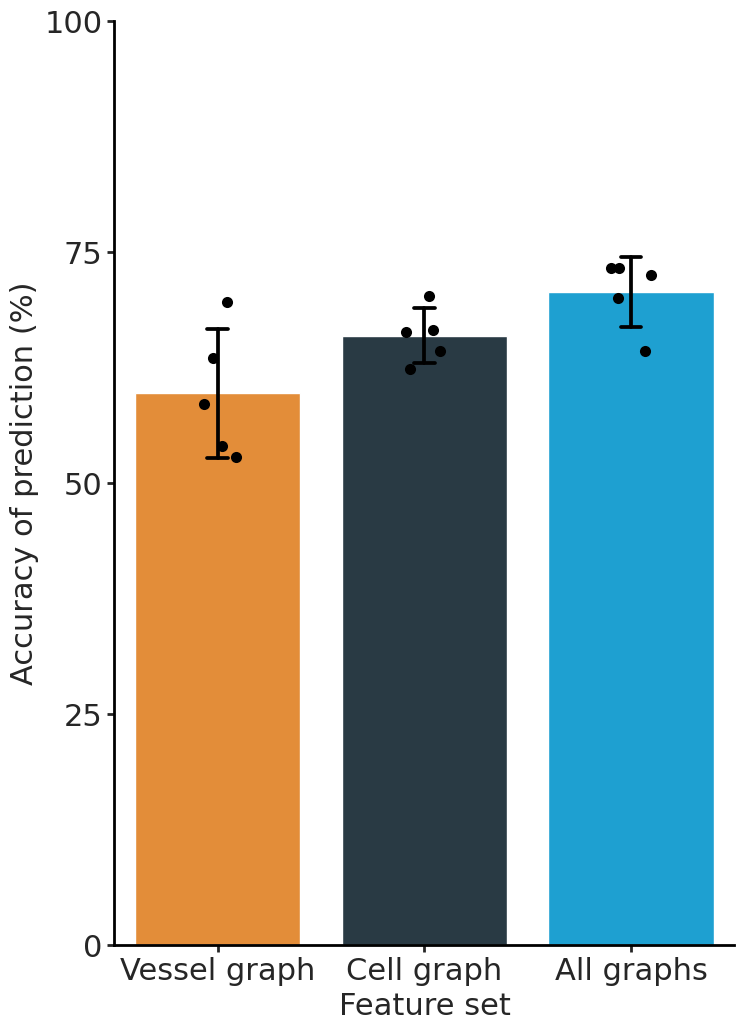

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(8, 12))

# Sample data: categories and multiple values per category
auc_all = np.concatenate((aucs_vessel, aucs_cell, aucs_comb), axis = None)
data = {
    'Category': ['Vessel graph', 'Vessel graph', 'Vessel graph', 'Vessel graph', 'Vessel graph',
           'Cell graph', 'Cell graph', 'Cell graph', 'Cell graph', 'Cell graph',
           'All graphs', 'All graphs', 'All graphs', 'All graphs', 'All graphs'],
    'Values': auc_all * 100
}

bar_colors = ['#ff8d1d', '#253b48', '#00aeef']  # Blue, Red, Green, Orange
error_color = 'black'

# Create a Seaborn bar plot with error bars
sns.barplot(x='Category', y='Values', data=data, ci='sd', capsize=0.1, palette=bar_colors, errcolor=error_color)

# Adding individual data points using stripplot
sns.stripplot(x='Category', y='Values', data=data, color='black', size=8, jitter=True)

# Adding title and labels
plt.ylabel('Accuracy of prediction (%)', fontsize=22)
sns.despine(top=True, right=True)
plt.tick_params(axis='both', which='both', bottom=True, left=True, width=2, length=5)
plt.yticks([0, 25, 50, 75, 100], fontsize=22)
plt.xticks(fontsize=22)
plt.xlabel('Feature set', fontsize=22)  # Removing x-axis title/label

# Access the current Axes instance
ax = plt.gca()

# Customize grid lines
ax.xaxis.grid(False)  # Disable x grid lines
ax.yaxis.grid(False)   # Enable y grid lines
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(2)
#plt.show()
plt.savefig("AUC_Barplot.png", dpi=300)
